In [1]:
from pyspark.sql import SparkSession

In [2]:
from pyspark.sql.functions import col, count, max, desc, from_unixtime, udf

In [3]:
from pyspark.sql.types import DateType, IntegerType

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
spark = SparkSession.builder.appName("PySpark").master("local[*]").getOrCreate()

In [6]:
spark

In [8]:
# spark.stop()

In [7]:
df = spark.read.format("parquet").load("../data/test")

In [8]:
df.printSchema()

root
 |-- instanceId_userId: integer (nullable = true)
 |-- instanceId_objectType: string (nullable = true)
 |-- instanceId_objectId: integer (nullable = true)
 |-- audit_pos: long (nullable = true)
 |-- audit_clientType: string (nullable = true)
 |-- audit_timestamp: long (nullable = true)
 |-- audit_timePassed: long (nullable = true)
 |-- audit_experiment: string (nullable = true)
 |-- audit_resourceType: long (nullable = true)
 |-- metadata_ownerId: integer (nullable = true)
 |-- metadata_ownerType: string (nullable = true)
 |-- metadata_createdAt: long (nullable = true)
 |-- metadata_authorId: integer (nullable = true)
 |-- metadata_applicationId: long (nullable = true)
 |-- metadata_numCompanions: integer (nullable = true)
 |-- metadata_numPhotos: integer (nullable = true)
 |-- metadata_numPolls: integer (nullable = true)
 |-- metadata_numSymbols: integer (nullable = true)
 |-- metadata_numTokens: integer (nullable = true)
 |-- metadata_numVideos: integer (nullable = true)
 |-- me

In [9]:
print("The dataframe has {} rows.".format(df.count()))

The dataframe has 1181443 rows.


In [10]:
# Посмотрим на количество каждого типа объекта
df.groupby("instanceId_objectType").count().show()

+---------------------+-------+
|instanceId_objectType|  count|
+---------------------+-------+
|                Video|  32561|
|                Photo|  83493|
|                 Post|1065389|
+---------------------+-------+



## Какая группа пользовалась популярностью, для каждого типа?

Всего 3 типа объекта, найдем самый популярный объект для каждого типа

In [11]:
df.where(df["instanceId_objectType"] == "Video") \
    .groupby("instanceId_objectId") \
    .agg(count(col("instanceId_objectId")).alias("count_group")) \
    .sort(desc("count_group")) \
    .show(1)

+-------------------+-----------+
|instanceId_objectId|count_group|
+-------------------+-----------+
|            9462035|        488|
+-------------------+-----------+
only showing top 1 row



In [12]:
df.where(df["instanceId_objectType"] == "Photo") \
    .groupby("instanceId_objectId") \
    .agg(count(col("instanceId_objectId")).alias("count_group")) \
    .sort(desc("count_group")) \
    .show(1)

+-------------------+-----------+
|instanceId_objectId|count_group|
+-------------------+-----------+
|            8296214|        112|
+-------------------+-----------+
only showing top 1 row



In [13]:
df.where(df["instanceId_objectType"] == "Post") \
    .groupby("instanceId_objectId") \
    .agg(count(col("instanceId_objectId")).alias("count_group")) \
    .sort(desc("count_group")) \
    .show(1)

+-------------------+-----------+
|instanceId_objectId|count_group|
+-------------------+-----------+
|           37256411|        525|
+-------------------+-----------+
only showing top 1 row



In [14]:
# Проверим
df_01 = df.groupby("instanceId_objectType", "instanceId_objectId").count()

In [15]:
df_01.show(5)

+---------------------+-------------------+-----+
|instanceId_objectType|instanceId_objectId|count|
+---------------------+-------------------+-----+
|                 Post|           38727626|   86|
|                 Post|           38474134|    5|
|                 Post|           21566738|   65|
|                 Post|           38124022|  115|
|                 Post|           21306933|    2|
+---------------------+-------------------+-----+
only showing top 5 rows



In [16]:
df_01 \
    .groupBy("instanceId_objectType") \
    .agg(max(col("count")).alias("max_count")).show()

+---------------------+---------+
|instanceId_objectType|max_count|
+---------------------+---------+
|                Video|      488|
|                Photo|      112|
|                 Post|      525|
+---------------------+---------+



In [17]:
df_03 = df \
    .groupby("instanceId_objectType", "instanceId_objectId") \
    .agg(count(col("instanceId_objectId")).alias("count_group"))

In [18]:
df_04 = df_01.groupBy("instanceId_objectType").agg(max(col("count")).alias("max_count"))

In [19]:
cond = [df_03.instanceId_objectType == df_04.instanceId_objectType, df_03.count_group == df_04.max_count]

In [20]:
df_03.join(df_04, cond).show()

+---------------------+-------------------+-----------+---------------------+---------+
|instanceId_objectType|instanceId_objectId|count_group|instanceId_objectType|max_count|
+---------------------+-------------------+-----------+---------------------+---------+
|                Photo|            8296214|        112|                Photo|      112|
|                 Post|           37256411|        525|                 Post|      525|
|                Video|            9462035|        488|                Video|      488|
+---------------------+-------------------+-----------+---------------------+---------+



## Построите гистограммы популярности/активности по времени суток

Сначала определимся, что в сутках у нас есть 4 времени, на каждое время по 6 часов:
- Утро: с 6.00 до 12.00
- День: с 12.00 до 18.00
- Вечер: с 18.00 до 0.00
- Ночь: с 0.00 до 6.00

__Сделаем преобразование юниксового времени в формат timestamp__

In [21]:
df = df.withColumn("timestamp_mili", (col("audit_timestamp")/1000).cast("timestamp"))

__Добавим новую колонку по часам__

In [22]:
hour = udf(lambda x: x.hour, IntegerType())

In [23]:
df = df.withColumn("hour", hour("timestamp_mili"))

In [24]:
# Проверим
df[["instanceId_objectId", "timestamp_mili", "hour"]].show(5)

+-------------------+--------------------+----+
|instanceId_objectId|      timestamp_mili|hour|
+-------------------+--------------------+----+
|             549335|2018-03-27 10:56:...|  10|
|           38727626|2018-03-28 17:51:...|  17|
|           14594128|2018-03-31 10:15:...|  10|
|           35364024|2018-03-25 16:03:...|  16|
|           21498907|2018-03-31 15:58:...|  15|
+-------------------+--------------------+----+
only showing top 5 rows



### Утро

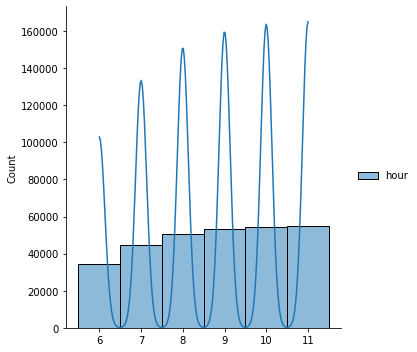

In [36]:
sns.displot(df[["hour"]].where((df["hour"] >= 6) & (df["hour"] < 12)).toPandas(), discrete=True, kde=True)

### День

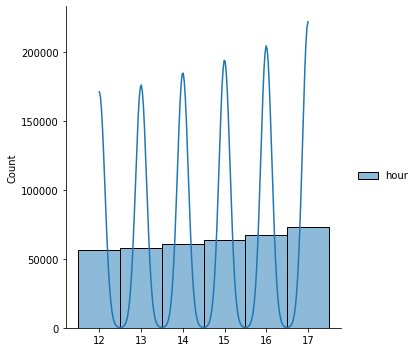

In [37]:
sns.displot(df[["hour"]].where((df["hour"] >= 12) & (df["hour"] < 18)).toPandas(), discrete=True, kde=True)

### Вечер

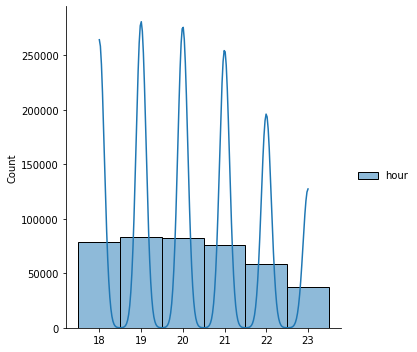

In [38]:
sns.displot(df[["hour"]].where((df["hour"] >= 18) & (df["hour"] < 24)).toPandas(), discrete=True, kde=True)

### Ночь

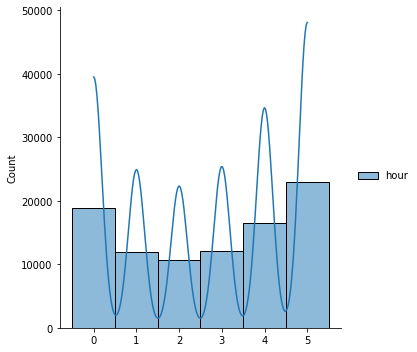

In [39]:
sns.displot(df[["hour"]].where((df["hour"] >= 0) & (df["hour"] < 6)).toPandas(), discrete=True, kde=True)

### Общая по часам

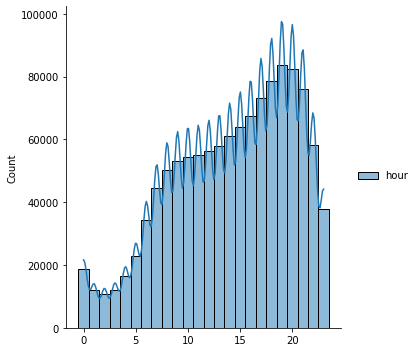

In [41]:
sns.displot(df[["hour"]].toPandas(), discrete=True, kde=True)